# Education in Denmark 2008-2019

The scope of this project is to examine the development of the level of education in Denmark using data from Denmark Statistisk. First, we examine the overall development of education in Denmark with data on highest education completed. Second, we examine this development by ancestry and, finally by gender. 

Imports and set magics:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets #install with pip install ipywidgets
import numpy as np
from matplotlib import cm

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Local modules
import dataproject

# Import pydst
import pydst
dst = pydst.Dst(lang='en')

# 1. Read and clean data

We read the highest completed education data from dst and clean it:

In [2]:
educ_vars = dst.get_variables(table_id='HFUDD10')
educ_vars

# Download data
educ = dst.get_data(table_id = 'HFUDD10', variables={'Tid':['*'],'HERKOMST':['*'], 'HFUDD':['TOT','H10','H20','H30', 'H40','H50','H60','H70'], 'KØN':['*']})

# Drop columns
drop_these = ['BOPOMR','ALDER']
educ.drop(drop_these, axis=1, inplace=True)

# Rename columns
educ.rename(columns = {'HERKOMST':'Ancestry', 'KØN':'Gender', 'TID':'Year', 'HFUDD':'HCEDUC', 'INDHOLD':'Units'}, inplace=True)

# Set index to year
educ['HCEDUC']=educ.HCEDUC.astype(str).str[4:]
educ.set_index('Year')
educ.head()

,Year,Ancestry,HCEDUC,Gender,Units
0,2006,Descendant,Primary education,Women,8201
1,2006,Descendant,Primary education,Men,9614
2,2006,Descendant,Primary education,Total,17815
3,2006,Descendant,Upper secondary education,Women,2485
4,2006,Descendant,Upper secondary education,Men,2001


# Merge with population data set

## Clean the population data set

We want to compare the level of education by ancestry. Therefor, we have to take into account that the numbers of people within each ancestry are uneven. Thus, we merge with population data by ancestry in order to calculate the share of individuals with completed education by ancestry relative to the number of individuals within ancestries.


In [3]:
# Download population data from dst
pop = dst.get_data(table_id = 'FOLK1C', variables={'Tid':['*'], 'HERKOMST':['*'], 'KØN':['*']})

# Drop columns
drop_these = drop_these = ['OMRÅDE','ALDER', 'IELAND']
pop.drop(drop_these, axis=1, inplace=True)

# Rename columns
pop.rename(columns = {'HERKOMST':'Ancestry', 'KØN':'Gender', 'TID':'Year','INDHOLD':'Pop'}, inplace=True)

for val in ['Q2','Q3','Q4']: 
    I = pop.Year.str.contains(val)
    pop.drop(pop[I].index, inplace=True)

pop.Year.astype(str)
pop['Year']= pop.Year.astype(str).str[:4]


## Merge the datasets

We see that the two datasets do not cover the same years. We want to be able to calculate shares for all observations included our analysis, so we merge the data using the inner method. Thus, we will be left with data for 2008 - 2019.

In [4]:
print(f'Years in education data = {educ.Year.unique()}')
print(f'Years in education data = {pop.Year.unique()}')

Years in education data = [2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]
Years in education data = ['2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017'
 '2018' '2019' '2020']


In [5]:
# Merge population data with data of highest education completed 
pop.Year = pop.Year.astype(int)
merged = pd.merge(educ, pop, how='inner',on=['Year','Ancestry','Gender'])
merged.head(10)

,Year,Ancestry,HCEDUC,Gender,Units,Pop
0,2008,Descendant,Primary education,Women,9995,58393
1,2008,Descendant,Upper secondary education,Women,3159,58393
2,2008,Descendant,Vocational Education and Training (VET),Women,2273,58393
3,2008,Descendant,Short cycle higher education,Women,395,58393
4,2008,Descendant,Vocational bachelors educations,Women,1048,58393
5,2008,Descendant,Bachelors programmes,Women,397,58393
6,2008,Descendant,Masters programmes,Women,610,58393
7,2008,Descendant,l,Women,19010,58393
8,2008,Descendant,Primary education,Men,11987,60904
9,2008,Descendant,Upper secondary education,Men,2454,60904


## Calculate shares

In [6]:
# Make a new column with calculated shares
merged['Share'] = merged['Units']/merged['Pop'] * 100
merged.head(10)

,Year,Ancestry,HCEDUC,Gender,Units,Pop,Share
0,2008,Descendant,Primary education,Women,9995,58393,17.116778
1,2008,Descendant,Upper secondary education,Women,3159,58393,5.409895
2,2008,Descendant,Vocational Education and Training (VET),Women,2273,58393,3.892590
3,2008,Descendant,Short cycle higher education,Women,395,58393,0.676451
4,2008,Descendant,Vocational bachelors educations,Women,1048,58393,1.794736
5,2008,Descendant,Bachelors programmes,Women,397,58393,0.679876
6,2008,Descendant,Masters programmes,Women,610,58393,1.044646
7,2008,Descendant,l,Women,19010,58393,32.555272
8,2008,Descendant,Primary education,Men,11987,60904,19.681794
9,2008,Descendant,Upper secondary education,Men,2454,60904,4.029292


# Graphical analysis

## Education level in Denmark 2008-2019

In order to get an overview of the development in the highest completed education of the population, we make a stacked bar plot of the share of people having each education as the highest they have completed.

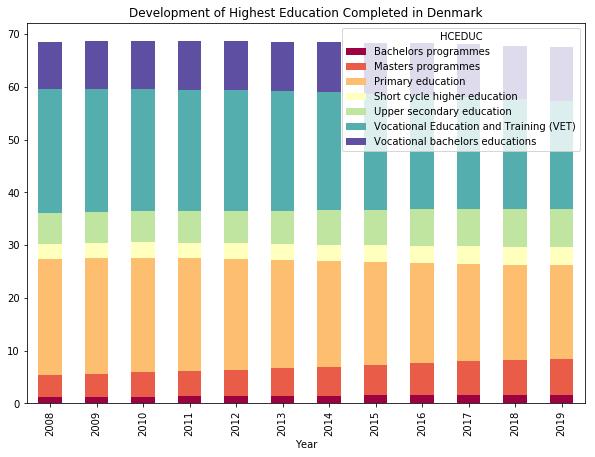

In [7]:
# Make a copy of the merged dataset
merged1 = merged.copy()

# Drop gender from dataset
for val in ['Men', 'Women']: 
    I = merged1.Gender.str.contains(val)
    merged1 = merged1.loc[I == False] # keep everything else

# Drop ancestry from dataset
for val in ['Descendant','Immigrants','Persons of Danish origin']: 
    J = merged1.Ancestry.str.contains(val)
    merged1 = merged1.loc[J == False] 

#Make a pivot table and use it to make a stacked bar plot
pivot = merged1.pivot(index='Year', columns='HCEDUC', values='Share')
pivot.drop('l',axis=1,inplace=True)
pivot.plot.bar(stacked=True, figsize=(10,7), title='Development of Highest Education Completed in Denmark',colormap='Spectral')


We see three clear trends in the figure: 

1. The share of people with upper secondary education as their highest education level has increased from 2008 to 2019 
2. The share of people with primary education as their highest education has decreased from 2008 to 2019
3. The share of people with master programmes has increased from 2008 to 2019

## Education level by ancestry 2008-2019

We wish to get an overview of the development in the different education levels by ancestry. 


We wish to normalize the first observation within each ancestry within each type of education. This makes the comparison of development between ancestries more straight forward. We use the split-apply-combine method to make a column containing the first observation within each ancestry within each education, so we can normalize the data.

Last, we construct a plot with a dropdown menu for choosing the education of interest.

In [8]:
merged.set_index('Year')
merged2 = merged.copy()

# Drop gender from the dataset
for val in ['Men', 'Women']: 
    I = merged2.Gender.str.contains(val)
    merged2 = merged2.loc[I == False] # keep everything else

# a. Split the dataset
merged_grouped = merged2.groupby(['Ancestry', 'HCEDUC'])
merged_grouped_first = merged_grouped.Share.first()
merged_grouped_first.name = 'first'

# b. Apply 
merged2.set_index(['Ancestry','HCEDUC','Year'],inplace=True)
merged2 = merged2.join(merged_grouped_first,how='left',on=['Ancestry','HCEDUC'])
merged2.reset_index(inplace=True)

# c. combine
merged2['indexed'] = merged2['Share']/merged2['first']

# plot
def plot_index(dataframe, Educations):
    dataframe_indexed = dataframe.set_index(['Year'])
    I = dataframe_indexed.HCEDUC == Educations
    dataframe_indexed[I].groupby(['Ancestry'])['indexed'].plot(legend=True);
    
def plot_index_i(dataframe):
    widgets.interact(plot_index, dataframe = widgets.fixed(dataframe), 
    Educations=widgets.Dropdown(decription='Education', options=dataframe.HCEDUC.unique())
); 
    
#plot_index_i(educ1)
plot_index_i(merged2)

interactive(children=(Dropdown(description='Educations', options=('Primary education', 'Upper secondary educat…

We see that the share of descendants has increased within any education level, implying that more and more descendants complete an education at all levels. The share is only slightly dropping in primary education, which most likely is a sign of them educating further. Another clear trend is that the share of people getting a university degree is increasing. The increase in master degrees is steepest for descendants, next for imimigrants and then for persons of danish origin. 

We wish to examine the development in master programmes further, as education is positively correlated with income, thus the development in master degrees is very interesting for income and social structures.

## Education share by gender

We want to examine the development in the share of people with master programmes as their highest education. Therefor, we are interested in the development of people with master programmes by gender wihtin ancestries, to see whether the development is driven by men, women or both. 

In [9]:
#Only select the number of people with completed master programmes as their highest education
for val in ['Masters programmes']: 
    I = merged.HCEDUC.str.contains(val)
    merged = merged.loc[I == True] 
merged.head(10)

,Year,Ancestry,HCEDUC,Gender,Units,Pop,Share
6,2008,Descendant,Masters programmes,Women,610,58393,1.044646
14,2008,Descendant,Masters programmes,Men,701,60904,1.150992
22,2008,Descendant,Masters programmes,Total,1311,119297,1.098938
30,2008,Immigrants,Masters programmes,Women,10899,192713,5.655560
38,2008,Immigrants,Masters programmes,Men,12721,185952,6.841013
46,2008,Immigrants,Masters programmes,Total,23620,378665,6.237704
54,2008,Persons of Danish origin,Masters programmes,Women,91338,2512019,3.636039
62,2008,Persons of Danish origin,Masters programmes,Men,117850,2465810,4.779363
70,2008,Persons of Danish origin,Masters programmes,Total,209188,4977829,4.202394
78,2008,Total,Masters programmes,Women,102847,2763125,3.722126


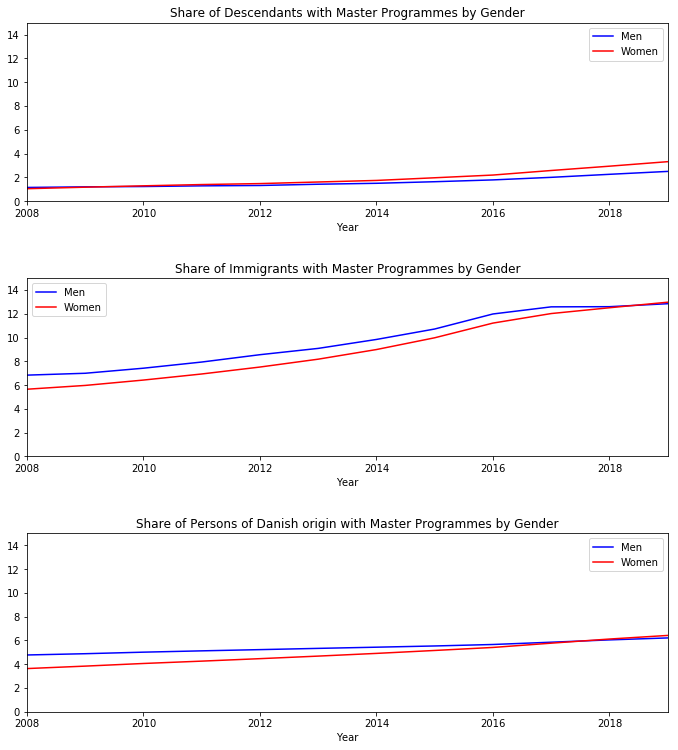

In [11]:
# Make a figure with 3 subplots 
plt.figure(figsize=(12,13))

#Figure 1: Plot with share of descendants with master programmes by gender
merged3 = merged.copy()
I = merged3.Ancestry == 'Descendant'
x = merged3[I]

ax = plt.subplot(311)

J = x.Gender == 'Men'
y1 = x[J]
y1.rename(columns = {'Share':'Men'}, inplace=True)
y1.plot(kind='line', x = 'Year', y='Men', ylim=(0,15), color='blue', ax=ax)

K = x.Gender == 'Women'
y2 = x[K]
y2.rename(columns = {'Share':'Women'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Women', ylim=(0,15), color='red', ax=ax)
ax.set_title('Share of Descendants with Master Programmes by Gender')

#Figure 2: Plot with share of immigrants with master programmes by gender
merged4 = merged.copy()
I = merged4.Ancestry == 'Immigrants'
x = merged4[I]

ax1 = plt.subplot(312)

J = x.Gender == 'Men'
y1 = x[J]
y1.rename(columns = {'Share':'Men'}, inplace=True)
y1.plot(kind='line', x = 'Year', y='Men', ylim=(0,15), color='blue', label='Men', ax=ax1)

K = x.Gender == 'Women'
y2 = x[K]
y2.rename(columns = {'Share':'Women'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Women', ylim=(0,15), color='red', ax=ax1, label='Women')
ax1.set_title('Share of Immigrants with Master Programmes by Gender')

#Figure 3: Plot with share of persons of danish origin with master programmes by gender
merged5 = merged.copy()
I = merged5.Ancestry == 'Persons of Danish origin'
x = merged5[I]

ax2 = plt.subplot(313)

J = x.Gender == 'Men'
y1 = x[J]
y1.rename(columns = {'Share':'Men'}, inplace=True)
y1.plot(kind='line', x = 'Year', y='Men', ylim=(0,15), color='blue', ax=ax2)

K = x.Gender == 'Women'
y2 = x[K]
y2.rename(columns = {'Share':'Women'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Women', ylim=(0,15), color='red', ax=ax2)
ax2.set_title('Share of Persons of Danish origin with Master Programmes by Gender')


plt.tight_layout(pad=10,h_pad=3,w_pad=20)

We see that the share of female descendants with a master degree increase more than the share of male descendants with a master degree from 2008 to 2019. In 2019 the share of female descendants with a master degree is around 0.5 percent higher than the share of male descendants with a master degree.  

In constrast, the gap between female immigrants and male immigrants with a master degree closes during the period in the analysis. In 2008 more men had a master degree as their highest education. The share of male immigrants with a master degree was about 7% and the share of female immigrants with a master degree was about 6%. Both shares increase to about 12-13%, but the increase in the share of female is higher. 

Finally, more men with danish origin had a master degree as their highest education in 2008, but again the gap between men and women closes from 2008 to 2019 with a higher increase in the share of women with a master degree relative to the increase in the share of men with a master degree. In 2019 the share of women with a master degree as their highest education just exceeded the share of men. 

We now want compare the share of men and women with master programmes as their highest education by ancestry. 


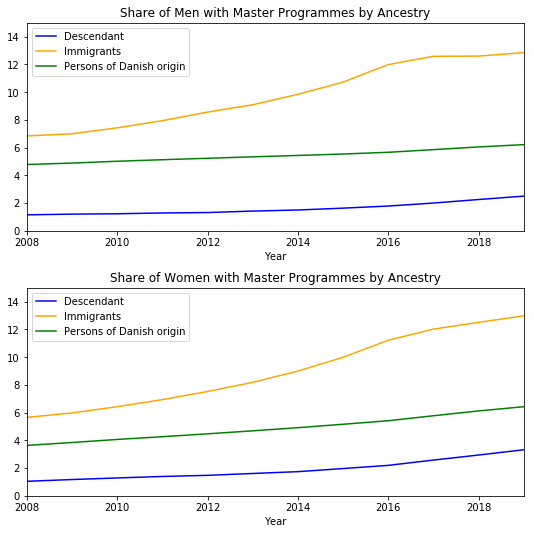

In [12]:
# Make a figure with 2 subplots 
plt.figure(figsize=(10,10))

#Figure 1: Plot with share of men with master programmes by ancestry
merged6 = merged.copy()
I = merged6.Gender == 'Men'
x = merged6[I]

ax = plt.subplot(211)

J = x.Ancestry == 'Descendant'
y1 = x[J]
y1.rename(columns = {'Share':'Descendant'}, inplace=True)
y1.plot(kind='line', x = 'Year', y='Descendant', ylim=(0,15), color='blue', ax=ax)

K = x.Ancestry == 'Immigrants'
y2 = x[K]
y2.rename(columns = {'Share':'Immigrants'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Immigrants', ylim=(0,15), color='orange', ax=ax)

K = x.Ancestry == 'Persons of Danish origin'
y2 = x[K]
y2.rename(columns = {'Share':'Persons of Danish origin'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Persons of Danish origin', ylim=(0,15), color='green', ax=ax)
ax.set_title('Share of Men with Master Programmes by Ancestry')

#Figure 2: Plot with share of women with master programmes by ancestry
merged7 = merged.copy()
I = merged7.Gender == 'Women'
x = merged7[I]

ax1 = plt.subplot(212)

J = x.Ancestry == 'Descendant'
y1 = x[J]
y1.rename(columns = {'Share':'Descendant'}, inplace=True)
y1.plot(kind = 'line', x = 'Year', y='Descendant', ylim=(0,15), color='blue', ax=ax1)

K = x.Ancestry == 'Immigrants'
y2 = x[K]
y2.rename(columns = {'Share':'Immigrants'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Immigrants', ylim=(0,15), color='orange', ax=ax1)

L = x.Ancestry == 'Persons of Danish origin'
y3 = x[L]
y3.rename(columns = {'Share':'Persons of Danish origin'}, inplace=True)
y3.plot(kind='line', x = 'Year', y='Persons of Danish origin', ylim=(0,15), color='green', ax=ax1)
ax1.set_title('Share of Women with Master Programmes by Ancestry')


plt.tight_layout(pad=10,h_pad=1,w_pad=10)

When comparing the share of men with a master degree by ancestry, we see that in 2008 the share of male immigrants with a master degree is the highest, it is around 7. The share of male immigrants with a master degrees also increase the most, which might represent that the male immigrants comming to Denmark are a special type. The share of male descendants with a master degreee as their higehst education is the lowest throughout the period, but the share increase from 1% in 2008 to 1.5% in 2019. 
The share of male descendants with a master degree increase more during the period of the analysis than the share of men with danish origin. 

The development of women with a master degree by ancestry is almost the same as for men. Again the share of female immigrants with a master degree as their highest education is the highest and also experience the highest increase during the period. The share of female descendants with a master degree increase from 1% in 2008 to 3% in 2019, and the share of women with danish origin with a master degree increase from 3.5% in 2008 to 5.5% in 2019. 

Note that the increase in the share of both females and males with master programmes can be due to changes in the size of age groups within each ancestry during the period as we have not taking age into account.



# Conclusion 

We find that the share of people who has primary education as their highest level of education has decreased from 2008 to 2019, while the share of people with upper secondary education and share of people with a master as their highest education level has increased. 

We see that the share of descandants increase for all education levels, representing an overall increase in level of education for descendants in Denmark. Further, we see that the share of people with a master programmes as their highest completed education has increased within all ancestries. 
The development is primarily driven by the increase in share of women with a master degree as their highest completed education. 

Last we find that the increase in the share of both female and male immigrants with a master degree as their highest education is the highest in percentage points. 